In [1]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import modules for splitting data, building stacking regressor, and evaluating models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
# Import libraries for handling JSON-like strings and interactive widgets
import ast
import json
from ipywidgets import interact, widgets
from IPython.display import display

In [2]:
# Load the financial dataset from a CSV file into a pandas DataFrame
data = pd.read_csv('financial_dataset.csv')

In [3]:
# Define a function to parse JSON strings in a column, handling potential errors and NaN values
def parse_json_column(col):
    return col.apply(lambda x: json.loads(x.replace("'", '"')) if pd.notnull(x) else {})

In [4]:
# Apply the parsing function to the 'market_context' and 'financial_indicators' columns
data['market_context'] = parse_json_column(data['market_context'])
data['financial_indicators'] = parse_json_column(data['financial_indicators'])
# Safely evaluate the 'aspect_sentiment_pairs' column which contains list-like strings
data['aspect_sentiment_pairs'] = data['aspect_sentiment_pairs'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

In [5]:
# Define a function to extract the sentiment score related to 'stock_price' from the parsed aspect-sentiment pairs
def extract_sentiment_score(row):
    if row['aspect_sentiment_pairs']:
        for aspect, sentiment in row['aspect_sentiment_pairs']:
            if aspect == 'stock_price':
                return 1 if sentiment == 'positive' else -1 if sentiment == 'negative' else 0
    return 0

In [6]:
# Apply the sentiment extraction function to create a new 'sentiment_score' column
data['sentiment_score'] = data.apply(extract_sentiment_score, axis=1)
# Extract 'price', 'volume', 'eps', 'revenue', and 'debt' values from the parsed JSON columns and create new columns
data['price'] = data['market_context'].apply(lambda x: x.get('price', np.nan))
data['volume'] = data['market_context'].apply(lambda x: x.get('volume', np.nan))
data['eps'] = data['financial_indicators'].apply(lambda x: x.get('eps', np.nan))
data['revenue'] = data['financial_indicators'].apply(lambda x: x.get('revenue', np.nan))
data['debt'] = data['financial_indicators'].apply(lambda x: x.get('debt', np.nan))

In [7]:
# Drop rows with any missing values in the specified key columns
data = data.dropna(subset=['sentiment_score', 'price', 'volume', 'eps', 'revenue', 'debt'])

In [8]:
# Remove outliers from numerical columns using the Interquartile Range (IQR) method
for column in ['price', 'volume', 'eps', 'revenue', 'debt']:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [9]:
# Convert 'date_time' column to datetime objects and sort data by ticker symbol and date/time
data['date_time'] = pd.to_datetime(data['date_time'])
data = data.sort_values(['ticker_symbol', 'date_time'])

In [10]:
# Create a lagged sentiment score feature (sentiment from the previous time step)
data['sentiment_score_lag1'] = data.groupby('ticker_symbol')['sentiment_score'].shift(1)
# Drop rows where the lagged sentiment score is not available (first entry for each ticker)
data = data.dropna(subset=['sentiment_score_lag1'])

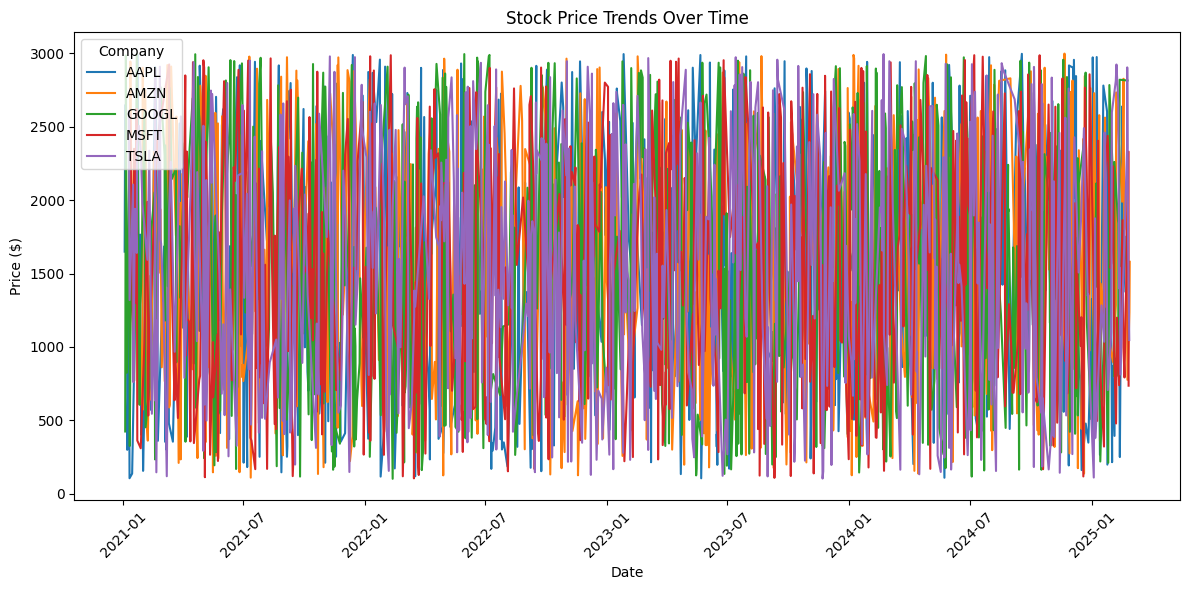

In [11]:
# Visualize stock price trends over time for different ticker symbols
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='date_time', y='price', hue='ticker_symbol')
plt.title('Stock Price Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)
plt.legend(title='Company')
plt.tight_layout()
plt.show()

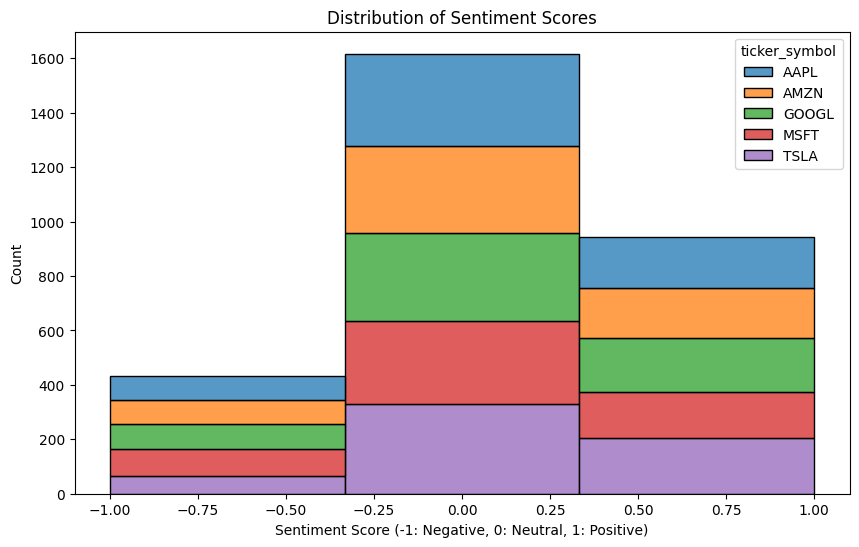

In [12]:
# Visualize the distribution of sentiment scores, separated by ticker symbol
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='sentiment_score', bins=3, hue='ticker_symbol', multiple='stack')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.show()

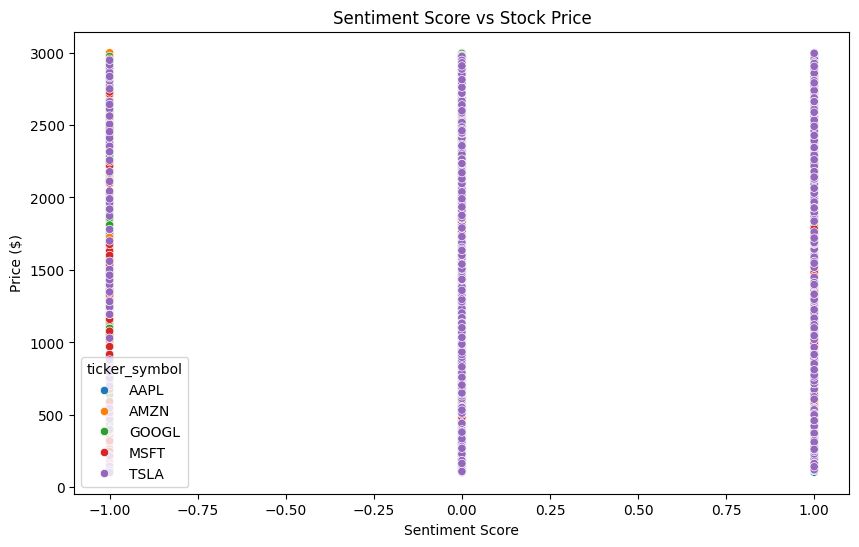

In [13]:
# Create a scatter plot to show the relationship between sentiment score and stock price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='sentiment_score', y='price', hue='ticker_symbol')
plt.title('Sentiment Score vs Stock Price')
plt.xlabel('Sentiment Score')
plt.ylabel('Price ($)')
plt.show()

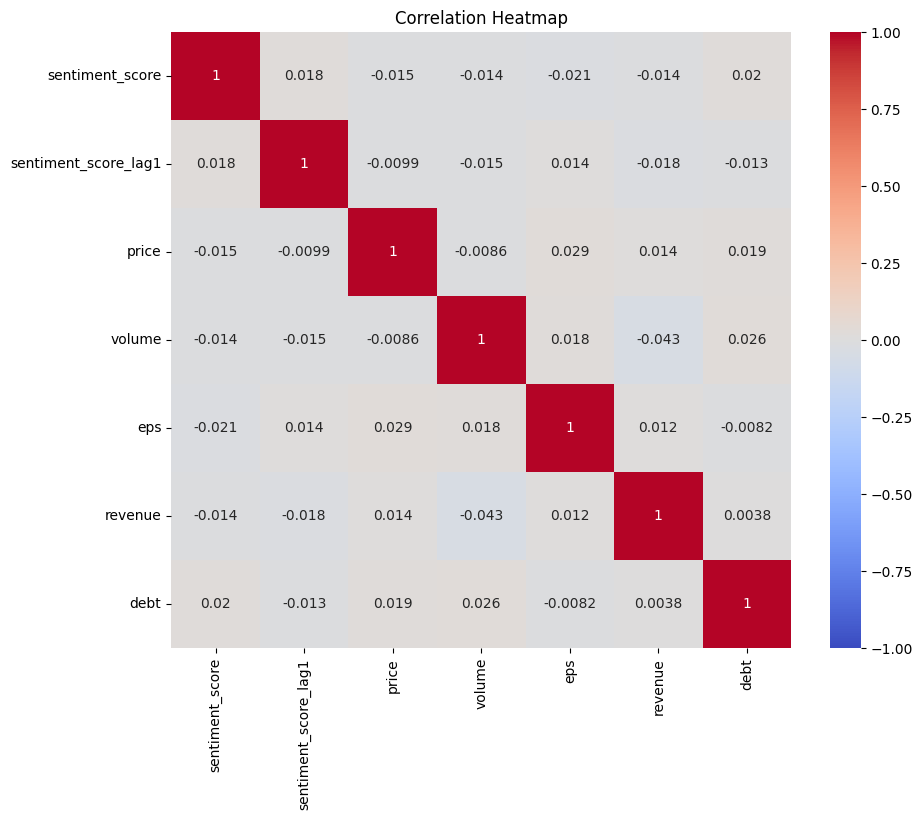

In [14]:
# Select relevant numeric columns for correlation analysis
numeric_data = data[['sentiment_score', 'sentiment_score_lag1', 'price', 'volume', 'eps', 'revenue', 'debt']]
# Generate and display a heatmap of the correlation matrix for the selected numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [15]:
# Aggregate data by date and ticker symbol to calculate the mean of relevant financial indicators and sentiment score
daily_data = data.groupby(['date_time', 'ticker_symbol']).agg({
    'sentiment_score': 'mean',
    'price': 'mean',
    'volume': 'mean',
    'eps': 'mean',
    'revenue': 'mean',
    'debt': 'mean'
}).reset_index()

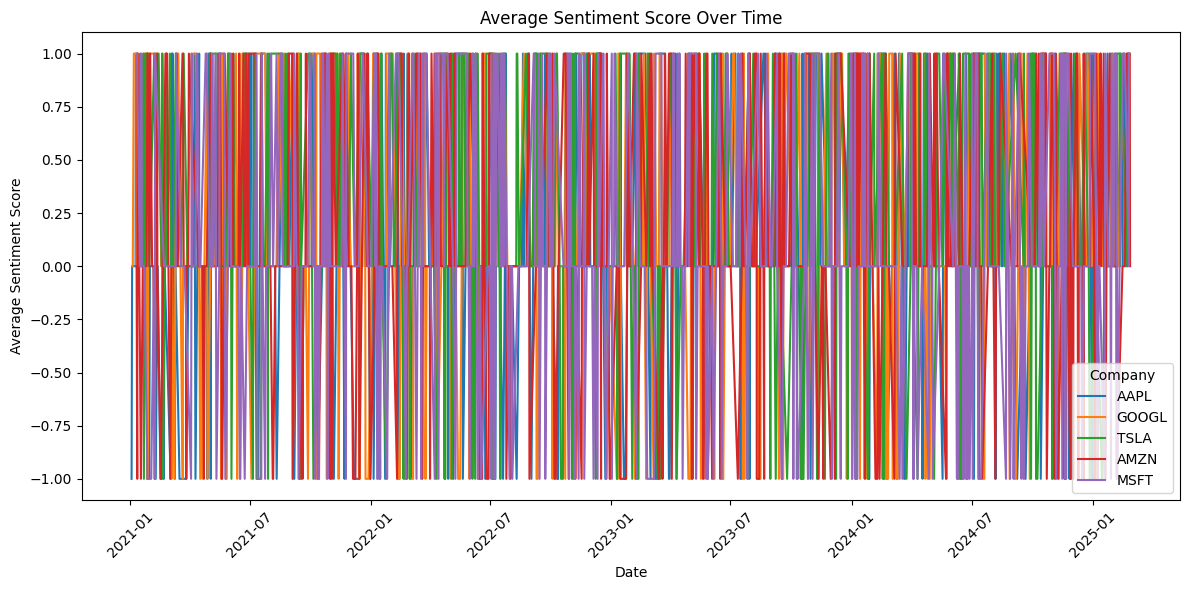

In [16]:
# Visualize the average sentiment score over time for each ticker symbol
plt.figure(figsize=(12, 6))
for company in daily_data['ticker_symbol'].unique():
    company_data = daily_data[daily_data['ticker_symbol'] == company]
    plt.plot(company_data['date_time'], company_data['sentiment_score'], label=company)
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Company')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Define a function to plot the average sentiment score over time for a specific company
def plot_company_sentiment(company):
    company_data = daily_data[daily_data['ticker_symbol'] == company]
    plt.figure(figsize=(12, 6))
    plt.plot(company_data['date_time'], company_data['sentiment_score'], label=company)
    plt.title(f'Average Sentiment Score Over Time for {company}')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

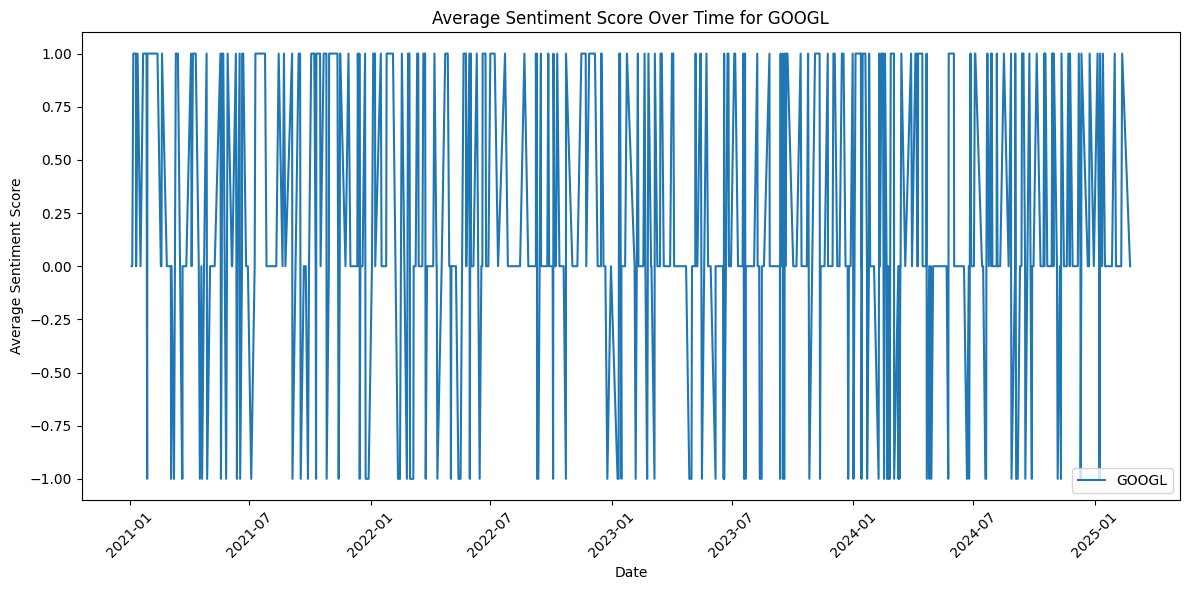

In [18]:
# Create an interactive widget to select a company and display its sentiment trend over time
companies = daily_data['ticker_symbol'].unique()
interact(plot_company_sentiment, company=widgets.Dropdown(options=companies, description='Company'))

In [19]:
# Define the features (X) and target variable (y) for the regression model
X = data[['sentiment_score', 'sentiment_score_lag1', 'volume', 'eps', 'revenue', 'debt']]
y = data['price']

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Define the base models for the stacking regressor (Random Forest and Gradient Boosting)
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))
]

In [22]:
# Initialize the Stacking Regressor with the defined base models and a final estimator (RidgeCV)
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV(),
    cv=5 # Use 5-fold cross-validation
)

In [23]:
# Train the stacking regressor model on the training data
stacking_regressor.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(random_state=42))],
                  final_estimator=RidgeCV())

In [24]:
# Make predictions on the test set using the trained stacking regressor
y_pred = stacking_regressor.predict(X_test)
# Calculate the Mean Squared Error (MSE) to evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
# Print the calculated Mean Squared Error
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 731048.3413231069


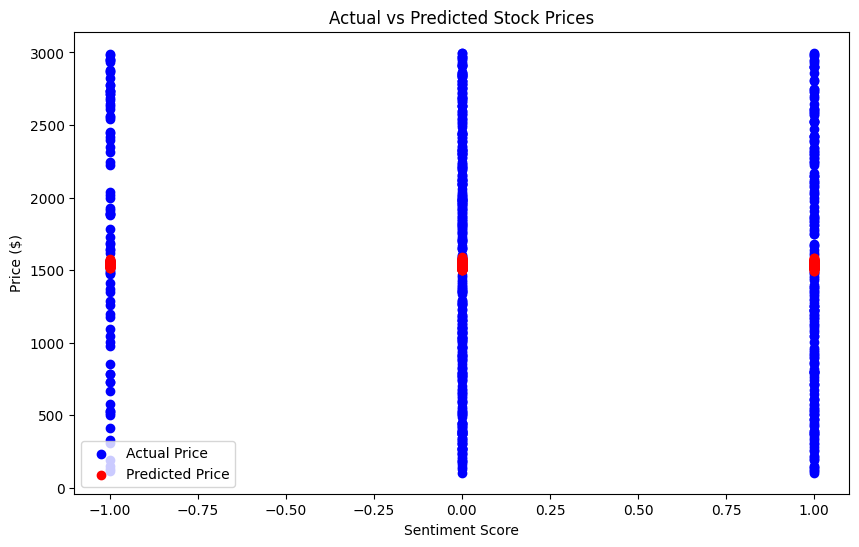

In [25]:
# Create a scatter plot to compare actual and predicted stock prices based on sentiment score
plt.figure(figsize=(10, 6))
plt.scatter(X_test['sentiment_score'], y_test, color='blue', label='Actual Price')
plt.scatter(X_test['sentiment_score'], y_pred, color='red', label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Sentiment Score')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [26]:
# Calculate and print the Pearson correlation coefficient between sentiment score and price
correlation = data['sentiment_score'].corr(data['price'])
print(f'Correlation between Sentiment Score and Price: {correlation}')

Correlation between Sentiment Score and Price: -0.014576634391193029


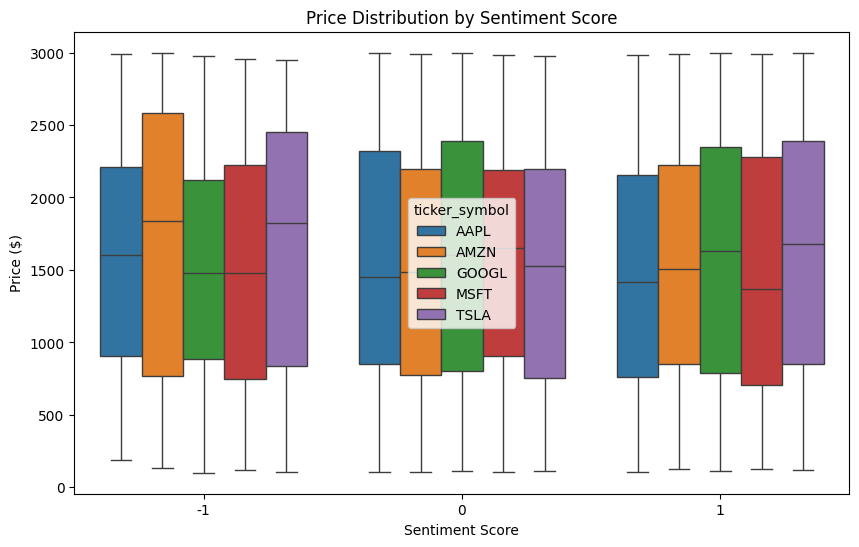

In [29]:
# Create a box plot to visualize the distribution of prices for each sentiment score category
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='sentiment_score', y='price', hue='ticker_symbol')
plt.title('Price Distribution by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Price ($)')
plt.show()

In [28]:
# Display the processed DataFrame
data

,text,cleaned_text,tokenized_text,pos_tags,named_entities,aspect_terms,aspect_positions,source_type,source_name,ticker_symbol,...,market_context,financial_indicators,aspect_sentiment_pairs,sentiment_score,price,volume,eps,revenue,debt,sentiment_score_lag1
2,market revenue revenue market revenue growth,market revenue revenue market revenue growth,market revenue revenue market revenue growth,VB VB VB VB VB VB,"Wall Street, Elon Musk","product_launch, stock_price","[2, 1]",news,Twitter,AAPL,...,"{'price': 1649.01, 'volume': 266702}","{'eps': -2.55, 'revenue': 380075986.32, 'debt'...","[(product_launch, positive), (stock_price, neg...",-1,1649.01,266702,-2.55,3.800760e+08,98953382.73,0.0
5,announcement drop profits growth shares launch...,announcement drop profits growth shares launch...,announcement drop profits growth shares launch...,VB VB VB VB VB VB VB VB VB,Apple,earnings,[7],news,Bloomberg,AAPL,...,"{'price': 2648.29, 'volume': 882064}","{'eps': 7.1, 'revenue': 240212858.03, 'debt': ...","[(earnings, negative)]",0,2648.29,882064,7.10,2.402129e+08,24163072.09,-1.0
9,market announcement launch announcement announ...,market announcement launch announcement announ...,market announcement launch announcement announ...,VB VB VB VB VB VB,NASDAQ,earnings,[1],earnings_call,YahooFinance,AAPL,...,"{'price': 1199.02, 'volume': 419386}","{'eps': -1.02, 'revenue': 784286531.35, 'debt'...","[(earnings, neutral)]",0,1199.02,419386,-1.02,7.842865e+08,45555335.90,0.0
10,shares drop drop shares CEO growth revenue mar...,shares drop drop shares ceo growth revenue mar...,shares drop drop shares ceo growth revenue mar...,VB VB VB VB NN VB VB VB VB VB VB,Wall Street,"earnings, regulation","[2, 0]",tweet,Reddit,AAPL,...,"{'price': 298.71, 'volume': 81262}","{'eps': 5.13, 'revenue': 235968691.11, 'debt':...","[(earnings, positive), (regulation, positive)]",0,298.71,81262,5.13,2.359687e+08,12076672.73,0.0
12,launch loss growth launch drop shares,launch loss growth launch drop shares,launch loss growth launch drop shares,VB VB VB VB VB VB,Google,"regulation, stock_price","[1, 2]",news,Bloomberg,AAPL,...,"{'price': 889.81, 'volume': 644210}","{'eps': -1.84, 'revenue': 343537407.51, 'debt'...","[(regulation, neutral), (stock_price, neutral)]",0,889.81,644210,-1.84,3.435374e+08,68780963.17,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2978,CEO launch market market announcement launch d...,ceo launch market market announcement launch d...,ceo launch market market announcement launch d...,NN VB VB VB VB VB VB VB VB VB,Google,"stock_price, earnings, earnings","[7, 7, 8]",news,Bloomberg,TSLA,...,"{'price': 811.62, 'volume': 239838}","{'eps': -0.87, 'revenue': 373697074.93, 'debt'...","[(stock_price, positive), (earnings, negative)...",1,811.62,239838,-0.87,3.736971e+08,13839675.37,0.0
2990,announcement launch growth shares CEO shares a...,announcement launch growth shares ceo shares a...,announcement launch growth shares ceo shares a...,VB VB VB VB NN VB VB VB VB,"Amazon, Apple",regulation,[0],tweet,Twitter,TSLA,...,"{'price': 2356.5, 'volume': 859493}","{'eps': 2.87, 'revenue': 777866949.39, 'debt':...","[(regulation, positive)]",0,2356.50,859493,2.87,7.778669e+08,5314058.13,1.0
2991,revenue loss drop announcement launch growth g...,revenue loss drop announcement launch growth g...,revenue loss drop announcement launch growth g...,VB VB VB VB VB VB VB NN NN VB VB,"Google, Elon Musk",stock_price,[1],news,Twitter,TSLA,...,"{'price': 2904.54, 'volume': 122917}","{'eps': -2.75, 'revenue': 494173181.13, 'debt'...","[(stock_price, positive)]",1,2904.54,122917,-2.75,4.941732e+08,5732805.09,0.0
2994,growth launch revenue CEO launch CEO market sh...,growth launch revenue ceo launch ceo market sh...,growth launch revenue ceo launch ceo market sh...,VB VB VB NN VB NN VB VB VB,Microsoft,stock_price,[2],tweet,Twitter,TSLA,...,"{'price': 1719.84, 'volume': 272816}","{'eps': 3.31, 'revenue': 987300175.26, 'debt':...","[(stock_